In [20]:


import os
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from tqdm import tqdm
from IPython.display import Audio, display

# --- Torch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# --- Rockpool & Neuromorphic Imports ---
from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TSContinuous
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [21]:
TRAIN_SEGMENTS_PATH = '/Users/mayuri/Neuromorphic Project/Dataset/building_106_kitchen/training_segments'
DATASET_PATH = '/Users/mayuri/Neuromorphic Project/SoundClassificationProject/SoundClassification/kitchen_spike_dataset/sample_info.npy'

fs = 110e3
raster_period = 10e-3
max_spike_per_raster_period = 15

afe = AFESim(
        fs=fs,
        raster_period=raster_period,
        max_spike_per_raster_period=max_spike_per_raster_period,
        add_noise=False,
        add_offset=False,
        add_mismatch=False,
        seed=None,
).timed()


In [22]:
def add_spike_noise(
    spikes,
    dropout_prob=0.05,
    jitter_prob=0.03,
    jitter_steps=1,
    background_prob=0.002
):
    
    noisy = spikes.copy()
    T, C = noisy.shape

    # 1. Spike Dropout
    keep_mask = np.random.rand(T, C) > dropout_prob
    noisy = noisy * keep_mask

    # 2. random changes in timing - temporal jitter
    jittered = np.zeros_like(noisy)
    jitter_mask = np.random.rand(T, C) < jitter_prob

    for t in range(T):
        for c in range(C):
            if noisy[t, c] > 0 and jitter_mask[t, c]:
                shift = np.random.randint(-jitter_steps, jitter_steps + 1)
                t_new = np.clip(t + shift, 0, T - 1)
                jittered[t_new, c] += noisy[t, c]
            else:
                jittered[t, c] += noisy[t, c]

    noisy = jittered

    # 3. Background Spikes
    bg_mask = np.random.rand(T, C) < background_prob
    noisy[bg_mask] += 1.0

    return noisy


In [23]:
class SpikeRasterDataset(Dataset):
    def __init__(self, sample_info_path, add_noise=True):
        self.sample_info = np.load(sample_info_path, allow_pickle=True)
        self.add_noise = add_noise

        self.old_root = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset'
        self.new_root = '/Users/mayuri/Neuromorphic Project/SoundClassificationProject/SoundClassification/kitchen_spike_dataset'

    def __len__(self):
        return len(self.sample_info)

    def __getitem__(self, idx):
        old_path, class_idx = self.sample_info[idx]
        current_path = str(old_path).replace(self.old_root, self.new_root)

        spikes = np.load(current_path)

        # adding noise here
        if self.add_noise:
            spikes = add_spike_noise(spikes)

        spikes = torch.from_numpy(spikes).float()
        return spikes, class_idx


In [24]:
dataset = SpikeRasterDataset(DATASET_PATH, add_noise=True)


In [25]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


In [26]:
# temporal SNN 
INPUT_CHANNELS = 16       
HIDDEN_NEURONS = 512      
OUTPUT_CLASSES = 24       
DT = 1e-2                 # 10ms

class ImprovedTemporalRSNN(nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch, dt):
        super().__init__()
        
        self.encoder = LinearTorch((in_ch, hidden_ch), has_bias=False)
        
        self.recurrent = Residual(
            LinearTorch((hidden_ch, hidden_ch), has_bias=False)
        )
        
        # Batch Norm for stability
        self.batch_norm = nn.BatchNorm1d(hidden_ch)
        
        # Long memory (200ms)
        self.lif_hidden = LIFTorch(
            shape=(hidden_ch,), 
            tau_mem=torch.tensor([100e-3]), 
            tau_syn=torch.tensor([100e-3]), 
            bias=torch.tensor(0.0),
            dt=dt
        )
        
        self.decoder = LinearTorch((hidden_ch, out_ch), has_bias=False)
        
        self.lif_out = LIFTorch(
            shape=(out_ch,), 
            tau_mem=torch.tensor([100e-3]),
            tau_syn=torch.tensor([100e-3]),
            dt=dt
        )

    def forward(self, x):
        # x: [Batch, Time, Channels]
        enc_out, _, _ = self.encoder(x)
        rec_out, _, _ = self.recurrent(enc_out)
        
        # Apply BatchNorm
        bn_in = rec_out.permute(0, 2, 1)
        bn_out = self.batch_norm(bn_in)
        bn_out = bn_out.permute(0, 2, 1)
        
        spikes_hidden, _, _ = self.lif_hidden(bn_out)
        dec_out, _, _ = self.decoder(spikes_hidden)
        spikes_out, _, _ = self.lif_out(dec_out)
        
        return spikes_out, None, None # Return tuple to match loop structure

net = ImprovedTemporalRSNN(INPUT_CHANNELS, HIDDEN_NEURONS, OUTPUT_CLASSES, DT)
net.to(device)

ImprovedTemporalRSNN(
  (encoder): LinearTorch  with shape (16, 512)
  (recurrent): TorchResidual  with shape (512, 512) {
      LinearTorch '0_LinearTorch' with shape (512, 512)
  }
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lif_hidden): LIFTorch  with shape (512, 512)
  (decoder): LinearTorch  with shape (512, 24)
  (lif_out): LIFTorch  with shape (24, 24)
)

In [27]:
# training loop
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 50

accuracy = []
loss_t = []

with tqdm(range(num_epochs), unit='Epoch', desc='Training') as pbar:
    for _ in pbar:
        correct = 0
        total = 0
        running_loss = 0
        
        net.train()

        for events, labels in train_loader:
            events = events.to(device)
            
            # Label conversion logic
            arr = np.array(labels, dtype=np.long)
            labels = torch.tensor(arr, dtype=torch.long).to(device)
            
            optimizer.zero_grad()

            # Forward pass
            output, _, _ = net(events)

            # Note: output shape is [Batch, Time, Classes]
            summed_output = torch.sum(output, dim=1) 

            loss = loss_fun(summed_output, labels)

            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            
            optimizer.step()

            # Calculate metrics
            predicted = torch.argmax(summed_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        this_accuracy = (correct / total) * 100
        this_loss = running_loss / len(train_loader) # Average loss per batch
        
        accuracy.append(this_accuracy)
        loss_t.append(this_loss)
        
        pbar.set_postfix(Loss=f'{this_loss:.2f}', Accuracy=f'{this_accuracy:.1f}%')

print(f"Final Training Accuracy: {accuracy[-1]:.3f}%")

Training: 100%|██████████| 50/50 [1:13:41<00:00, 88.43s/Epoch, Accuracy=54.3%, Loss=2.00]  

Final Training Accuracy: 54.316%


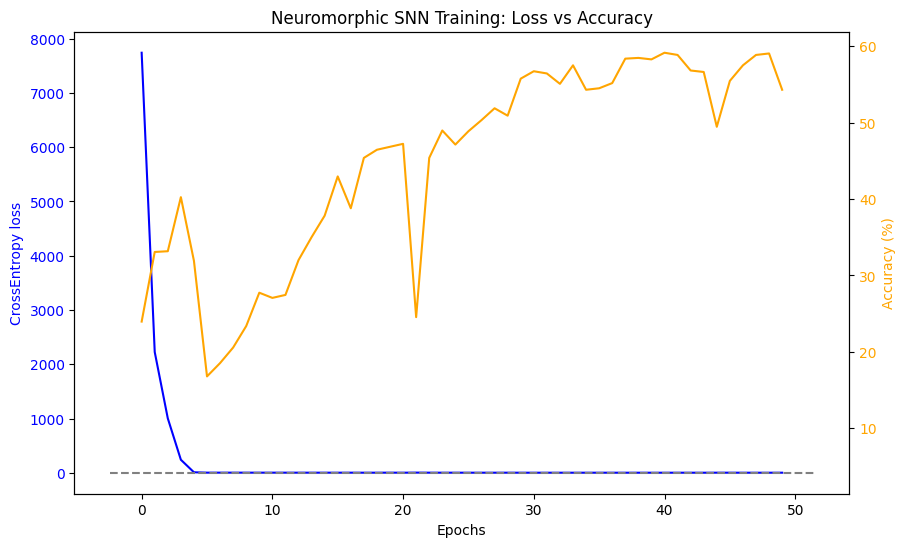

In [28]:
# Plot the Training Loss
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss_t, color='blue', label='Loss')
ax.set_ylabel('CrossEntropy loss', color='blue')
# ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.tick_params(axis='y', labelcolor='blue')

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange', label='Accuracy')
ax2.plot(ax2.get_xlim(), [100/OUTPUT_CLASSES, 100/OUTPUT_CLASSES], '--', color='gray', label='Chance Level')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.set_yscale('linear')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Neuromorphic SNN Training: Loss vs Accuracy')
plt.show()

In [29]:
net.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for events, labels in test_loader:
        events = events.to(device)
        
        arr = np.array(labels, dtype=np.long)
        labels = torch.tensor(arr, dtype=torch.long).to(device)
        
        output, _, _ = net(events)
        summed_output = torch.sum(output, dim=1)
        
        predicted = torch.argmax(summed_output, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = (test_correct / test_total) * 100
print(f"FINAL TEST ACCURACY: {test_acc:.2f}%")

FINAL TEST ACCURACY: 54.05%
